In [2]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
import utils.plot
import models.train_metaClf
import models.clusterUtils

In [3]:
savedir_processed='/data/xzhang/neuro/processed'
with open(os.path.join(savedir_processed,'allLatent_epoch458_nucSeg'), 'rb') as output:
    latent_all=pickle.load(output)

In [8]:

finalPartition,_=models.clusterUtils.getCluster(latent_all,None,resolution=4.08,n_pcs=200)
np.unique(finalPartition).size

69

In [9]:
resDir='/data/xzhang//neuro/results/plots/cnnvaeexp0_segNucall'
with open(os.path.join(resDir,'leiden_res4.08'), 'wb') as output:
    pickle.dump(finalPartition,output,pickle.HIGHEST_PROTOCOL)

<BarContainer object of 69 artists>

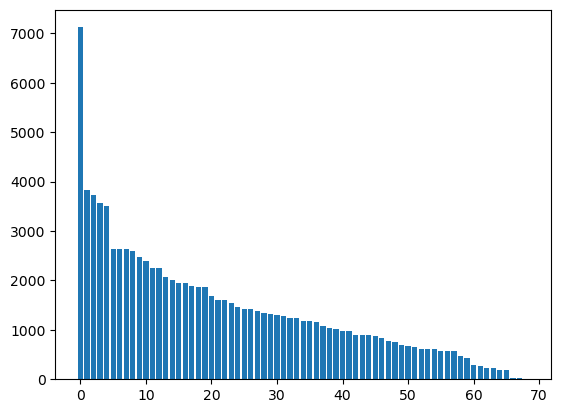

In [10]:
clusterUnique,clusterCount=np.unique(finalPartition,return_counts=True)
plt.bar(clusterUnique,clusterCount)

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
savedir_processed='/data/xzhang/neuro/processed'
resDir='/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall'


with open(os.path.join(resDir,'leiden_res4.08'), 'rb') as output:
    finalPartition=pickle.load(output)
    
with open(os.path.join(savedir_processed,'meta_processed'), 'rb') as output:
    meta=pickle.load(output)

# annoUsed=np.array(['AAO', 'AAD', 'Duration', 'Gender','Clinical Diag', 'Path Diag','Brain Weight', 'Mutations',
#                    'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43'])
annoUsed=np.array(['Path Diag','Clinical Diag','Brain Weight', 'Mutations',
                   'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43',
                   'AAO', 'AAD', 'Duration', 'Gender'])
annoUsed_numeric=np.array(['AAO', 'AAD', 'Duration','Brain Weight','Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD'])

meta=meta[annoUsed]
stains=np.array(['DAPI','GFAP','MAP2','LMNB'])

In [12]:
with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientIDs=pickle.load(output)
meta=meta.loc[np.unique(allPatientIDs)]

In [13]:
np.unique(finalPartition).size

69

In [14]:
savedir_analysis=os.path.join(resDir,'plots')
if not os.path.exists(savedir_analysis):
    os.mkdir(savedir_analysis)

In [15]:
with open(os.path.join(savedir_processed,'allImgNames'), 'rb') as output:
    allImgNames=pickle.load(output)
print(np.unique(allImgNames).size)
print(np.unique(allPatientIDs).size)

64
50


In [ ]:
seeds=[4,8,9,10,11,12]
# for anno in annoUsed:
for anno in ['Path Diag','Clinical Diag']:
    print(anno)
    regrs=False
#     if anno in annoUsed_numeric:
#         regrs=True
#     if anno not in annoUsed_numeric:
#         continue
        
    
    #construct labels
    
    meta['keep']=True
    if anno not in annoUsed_numeric:
        pathDiag_unique_keep,pathDiag_inverse_keep,pathDiag_counts_keep=np.unique(meta[anno].astype(str),return_counts=True,return_inverse=True)
        pathDiag_unique_keep[pathDiag_counts_keep<=1]='remove'
        pathDiag_unique_keep=pathDiag_unique_keep[pathDiag_inverse_keep]

        meta['keep']=pathDiag_unique_keep!='remove'
    
    meta_allcells=meta.loc[allPatientIDs][anno].to_numpy().astype(str)
    cellIdx=np.logical_and(meta_allcells!='na',meta_allcells!='nan')
    cellIdx=np.logical_and(cellIdx,meta.loc[allPatientIDs]['keep'].to_numpy())
    allCat=meta_allcells[cellIdx]
    
    allImgNames_a=allImgNames[cellIdx]
    sUnique,sidx_start=np.unique(allImgNames_a,return_index=True)
    
    #get cluster composition
    clusterUnique=np.unique(finalPartition)
    inputCluster=np.zeros((sUnique.size,clusterUnique.size))
    for i in range(sUnique.size):
        clusterRes_i=finalPartition[allImgNames==sUnique[i]]
        for j in range(clusterUnique.size):
            inputCluster[i,j]=np.sum(clusterRes_i==clusterUnique[j])
    inputAll=inputCluster/np.sum(inputCluster,axis=1,keepdims=True)

    if anno not in annoUsed_numeric:
        pathDiag_unique,labels,pathDiag_counts=np.unique(allCat[sidx_start],return_counts=True,return_inverse=True)
        weights=np.sum(pathDiag_counts)/pathDiag_counts
    else:
        pathDiag_unique=None
        weights=None
        labels=allCat[sidx_start].astype(float)
    if labels.size<2:
        continue
    annoName=anno
    if ' ' in anno:
        annoName=anno.split(' ')
        annoName=annoName[0]+'_'+annoName[1]
    for seed in seeds:
        print('seed: ',seed)
        name='exp0_allMetaClf_nucSeg_baselineAllLatent_res4.08_seed'+str(seed)+'_'+annoName
        savepath_curr=os.path.join(resDir,'metadataClf',name)
        if not os.path.exists(os.path.join(resDir,'metadataClf')):
            os.mkdir(os.path.join(resDir,'metadataClf'))
        if not os.path.exists(savepath_curr):
            os.mkdir(savepath_curr)
        logsavepath=os.path.join(savepath_curr,'log')
        modelsavepath=os.path.join(savepath_curr,'model')
        plotsavepath=os.path.join(savepath_curr,'plots')

        if os.path.exists(os.path.join(plotsavepath,'predictions'+str(5900)+'.csv')):
            continue

        if not os.path.exists(logsavepath):
            os.mkdir(logsavepath)
        if not os.path.exists(modelsavepath):
            os.mkdir(modelsavepath)
        if not os.path.exists(plotsavepath):
            os.mkdir(plotsavepath)

        pIDList=allPatientIDs[sidx_start]
        models.train_metaClf.train_metaClf(inputAll, pathDiag_unique, labels, logsavepath, modelsavepath, plotsavepath, pIDList, allImgNames, sidx_start,weights=weights, use_cuda=True, seed=seed, testepoch=3500, epochs=6000, saveFreq=100, lr=0.001, weight_decay=0, batchsize=32, model_str='fc3', fc_dim=256,regrs=regrs)